# Kaixin's 23Na(3He,d) data
See https://pfunk.readthedocs.io/en/latest/guide/bays_fit.html

### Import Packages

In [2]:
%matplotlib inline
import pfunk
import matplotlib.pyplot as plt
import corner
import pickle
import numpy as np
from scipy import stats
from scipy.signal import argrelmax
import copy
import os
import pandas as pd
from datetime import datetime
from KaixinSpecTools import * # Some code I wrote to calculate theoretical optical model parameters from model 
from scipy.stats import uniform # This is missing in pfunk and caused a bug
np.set_printoptions(suppress=True)

### Define paths, settings and parameter indices in fresco input file

In [3]:
path_main='/home/kaixin/Documents/23NaHe3d_Analysis' # main directory
path_mcmc=path_main+'/MCMC_20221002' #directory to store MCMC picle files and results
path_log=path_main+'/RunLog/'# directory to save information of each run
path_plots=path_main+'/Plots/'
level_list=['7349_twol','7747_twol','8358','8437_twol','8654_twol','8864','9146','9301','9458','9516','9828',\
            '10059_twol','10161','10333','10361','10731','10731_twol','10821','10821_twol','10917','11217','11217_twol','11314','11390',\
            '11453_twol','11695','11933']

In [4]:

# os.chdir(current_time)

In [5]:
iNorm = 0
iC2S  = 1
iD0=2
iScat = 3
# iTrans = 4
# iV=5 ## Index of first optical parameter
iAlpha = 4


In [6]:
now = datetime.now()
current_time = now.strftime("%Y%m%d_%H:%M")
fp = open(path_log+'/Log.txt', 'a')
fp.write(current_time)
fp.write('\t')
fp.write('\t')
separator = ','
fp.write("Save C2S from MCMC: "+separator.join(level_list))
fp.write('\n')
fp.close()


----

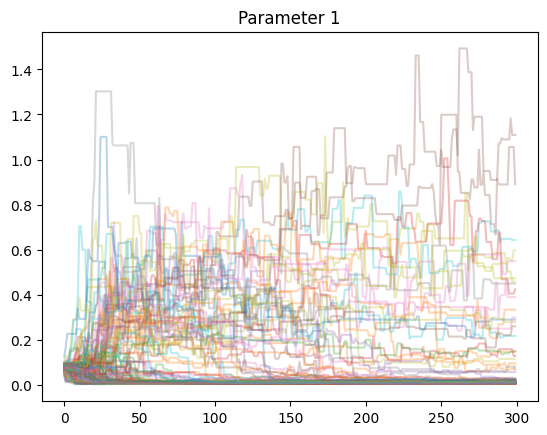

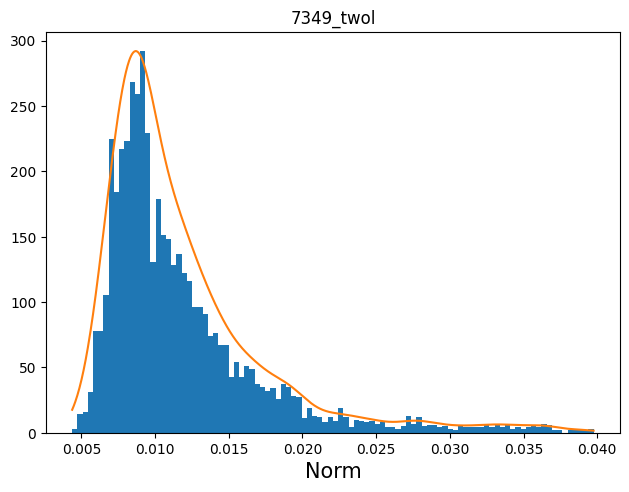

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f078eeafe50> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f078eee9790> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [7]:
labels = ['level','Norm','Norm+','Norm-','C2S','C2S+','C2S-','D0','D0+','D0-',\
          'Scat','Scat+','Scat-','Trans','Trans+','Trans-''Alpha','Alpha+','Alpha-',\
          'V_He','V_He+','V_He-',\
          'r0_He','r0_He+','r0_He-','a0_He','a0_He+','a0_He-','Wv_He','Wv_He+','Wv_He-',\
          'ri_He','ri_He+','ri_He-','ai_He','ai_He+','ai_He-','V_d','V_d+','V_d-',\
          'r0_d','r0_d+','r0_d-','a0_d','a0_d+','a0_d-','Wv_d','Wv_d+','Wv_d-',\
          'ri_d','ri_d+','ri_d-','ai_d','ai_d+','ai_d-','Ws_d','Ws_d+','Ws_d-']

with open(path_mcmc+"/MCMC_table.txt","w+") as outfile:  
    for label in labels:
        outfile.write(label)
        outfile.write("\t")
    outfile.write("\n")
    for level in level_list:
        samples = np.load(path_mcmc+'/samples-'+level+'.npy')
        ## Step 1 - discard the first Ndiscard samples from each chain
        Ndiscard = 100
        sliced_samples = samples[Ndiscard:,:,:]
        ## Step 2 - thin by Nthin
        Nthin = 5
        thinned_samples = sliced_samples[int(Nthin/2)::Nthin,:]
        ## Step 3 - flatten the chains
        flattened_samples = thinned_samples.reshape(-1,sliced_samples.shape[-1])
        s = flattened_samples
        snew=[]
        upperlim=np.average(np.percentile(s[:, 1], [16, 50, 84]))+\
            4*np.diff(np.percentile(s[:, 1], [16, 50, 84]))[1]
        if (level=='7349_twol'):
            upperlim=0.04
        if (level=='8358'):
            upperlim=0.017
        for i in range(0,len(s)):
        #     Filter=(s[i,iTrans]<0.04 and s[i,iTrans]>0)
            Filter=(s[i,iC2S]<upperlim and s[i,iC2S]>0)
            if(Filter):
                snew.append(s[i,:])
        s=np.array(snew)
        ## Plot one chain
        ipar = iC2S
        p = plt.plot(samples[:,:,ipar], alpha=0.3)
        plt.title('Parameter {}'.format(ipar))
        plt.savefig(path_plots+'/'+level+'_C2S_chain.png')
        plt.show()
        # Plot pdf

        xx = np.linspace(min(s[:,ipar]), max(s[:,ipar]), 1000)
        kde = stats.gaussian_kde(s[:,ipar])
        h = plt.hist(s[:,ipar],100)
        scale = max(h[0])/max(kde(xx))
        plt.plot(xx,scale*kde(xx))
        plt.xlabel(labels[ipar],fontsize=15)
        plt.tight_layout()
        plt.title(level)
        plt.savefig(path_plots+'/'+level+'_C2S.png')
        plt.show()
        # Plot corner
        if (level.find('_twol')>=0):
                    #          '$a_i$','$V$','$r_0$','$a_0$','$W_V$','$r_i$', '$a_i$','$W_S$']
            labels = ['$Norm$','$C^2S$','$D0$','$Scat.$','$Trans.$','$alpha$','$V$', '$r_0$', '$a_0$', '$W_V$','$r_i$', '$a_i$', 
                 '$a_i$','$V$','$r_0$','$a_0$','$W_V$','$r_i$', '$a_i$','$W_S$']
        else:
            labels = ['$Norm$','$C^2S$','$D0$','$Scat.$','$Trans.$','$V$', '$r_0$', '$a_0$', '$W_V$', '$r_i$', '$a_i$',
                 '$V$','$r_0$','$a_0$','$W_V$','$r_i$', '$a_i$','$W_S$']
        p = corner.corner(s, bins=50, smooth=1.5, labels=labels,
                  show_titles=True, title_kwargs={'fontsize':17.0},
                  label_kwargs={'fontsize':17.0})
        plt.savefig(path_plots+'/'+level+'_corner.png')
        plt.show()
        

        ndim = s.shape[-1]
        str=level+"\t"
        for i in range(ndim):
            if (ndim==17 and i==4):
                str=str+"0\t0\t0\t"
            mcmc = np.percentile(s[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = "{0:.4f}\t{2:.4f}\t-{1:.4f}\t"
            txt = txt.format(mcmc[1], q[0], q[1])
            str=str+txt
        str=str+"\n"
        #print(s[1000,:])
        outfile.write(str)
        print(str)


In [10]:
data=pd.read_csv(path_mcmc+'/MCMC_table.txt',sep='\t',lineterminator='\n')
data.loc[data['level']=='7747']['C2S']

Series([], Name: C2S, dtype: object)

In [11]:
data[["level", "C2S", "C2S+", "C2S-","Alpha","Alpha+","Alpha-"]]

KeyError: "['Alpha'] not in index"

In [13]:
data_latex=pd.read_csv(path_main+'/WorkSpreadSheets'+'/C2S_Results.csv',sep='\t',lineterminator='\n')

In [14]:
format="$%s$ & $%d^%s$ & %s & $%.2g^{+%.2g}_{%.2g}$ & %s\\\\ "
# latex output
for i in range(0,len(data_latex)):
    print(format % ((data_latex['Level'][i]/1000),data_latex['Jf'][i],data_latex['Parity'][i],\
                   data_latex['Orbital'][i],data_latex['(2J+1)C2S_MCMC'][i],\
                    data_latex['(2J+1)C2S_MCMC+'][i],data_latex['(2J+1)C2S_MCMC-'][i],data_latex['C2S_Lit.'][i]
                   ))

$7.349$ & $2^+$ & 2s1/2 & $0.019^{+0.0095}_{-0.0045}$ & 0.09\\ 
$7.349$ & $2^+$ & 1d5/2 & $0.014^{+0.0075}_{-0.005}$ & 0.1\\ 
$7.747$ & $1^-$ & 2s1/2 & $0.085^{+0.032}_{-0.022}$ & 0.32\\ 
$7.747$ & $1^-$ & 1d5/2 & $0.1^{+0.044}_{-0.03}$ & 0.58\\ 
$8.358$ & $3^-$ & 2p3/2 & $0.048^{+0.017}_{-0.011}$ & 0.08\\ 
$8.437$ & $1^-$ & 2p3/2 & $0.06^{+0.026}_{-0.022}$ & 0.28\\ 
$8.439$ & $4^+$ & 1d5/2 & $0.42^{+0.16}_{-0.12}$ & 1.04\\ 
$8.654$ & $2^+$ & 2s1/2 & $0.11^{+0.044}_{-0.028}$ & 0.34\\ 
$8.654$ & $2^+$ & 1d5/2 & $0.09^{+0.045}_{-0.03}$ & 0.41\\ 
$8.864$ & $2^-$ & 2p3/2 & $0.13^{+0.05}_{-0.03}$ & 0.39\\ 
$9.146$ & $1^-$ & 2p3/2 & $0.022^{+0.0078}_{-0.0054}$ & 0.0\\ 
$9.301$ & $2^+$ & 1d5/2 & $0.29^{+0.099}_{-0.062}$ & 0.58\\ 
$9.458$ & $3^+$ & 1d5/2 & $0.21^{+0.091}_{-0.052}$ & 0.49\\ 
$9.516$ & $4^+$ & 1d5/2 & $0.55^{+0.16}_{-0.12}$ & 1.2\\ 
$9.828$ & $1^+$ & 1d5/2 & $0.22^{+0.059}_{-0.046}$ & 0.54\\ 
$10.059$ & $1^+$ & 2s1/2 & $0.068^{+0.041}_{-0.032}$ & 0.22\\ 
$10.059$ & $1^+$ & 1d5/2

In [15]:


# plt.errorbar(x, y, yerr=asymmetric_error, fmt='.', color='black',ecolor = 'red',label='MyC2S',linewidth=1,capsize=2)
# plt.errorbar(x, y_lit, yerr=y_lit_err, fmt='.', color='blue',ecolor = 'blue',label='lit',linewidth=1,capsize=2)
# plt.legend()
# # plt.ylim(0,1)
# plt.yscale('log')

# plt.show()

# plt.scatter(x,y/y_lit,label='ratio')
# plt.legend()
# plt.show()


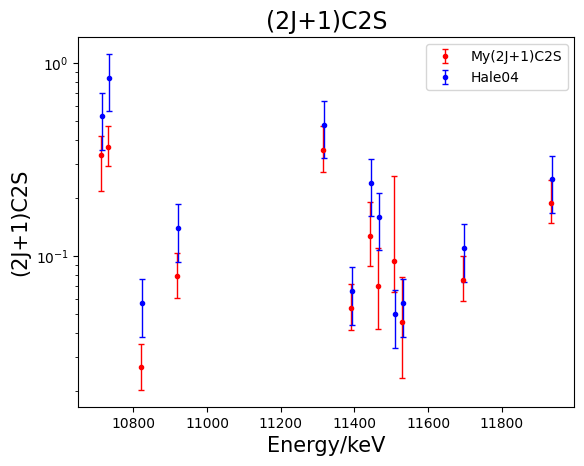

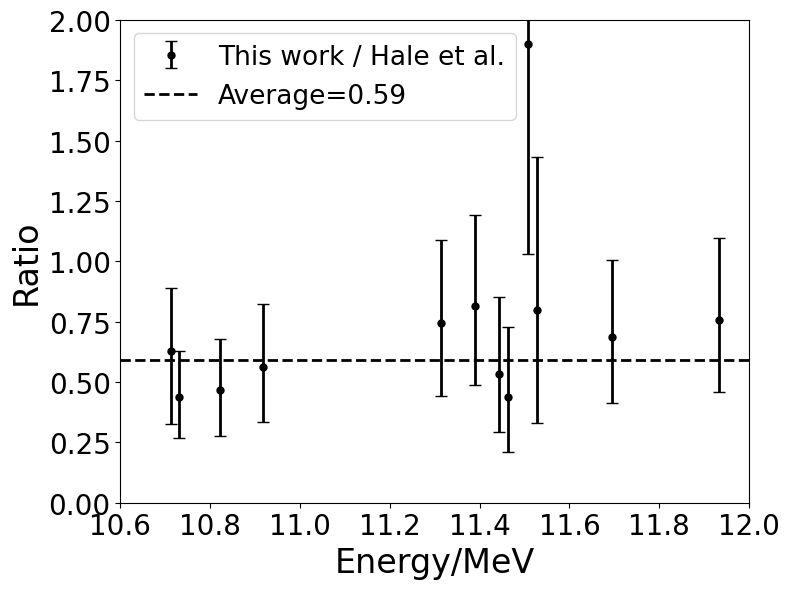

0.5928766089291311


In [20]:

data_lit_compare=pd.read_csv(path_main+'/WorkSpreadSheets'+'/C2S_Results_compare_Hale.csv',sep='\t',lineterminator='\n')
x = data_lit_compare['Level']
y=data_lit_compare['(2J+1)C2S_MCMC']

lower_error =  -data_lit_compare['(2J+1)C2S_MCMC-']
upper_error =  data_lit_compare['(2J+1)C2S_MCMC+']
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

y_lit=data_lit_compare['C2S_Lit.']
y_lit_err=0.33*y_lit
plt.errorbar(x, y, yerr=np.array(list(zip(lower_error, upper_error))).T, fmt='.', color='red',ecolor = 'red',label='My(2J+1)C2S',linewidth=1,capsize=2)
plt.yscale('log')
plt.title('(2J+1)C2S',fontsize=17)
plt.xlabel('Energy/keV',fontsize=15)
plt.ylabel('(2J+1)C2S',fontsize=15)
x_hale=np.array(x)
y_hale=np.array(y_lit)
plt.errorbar(x_hale+3, y_hale, yerr=0.33*y_hale, label='Hale04',fmt='.', color='blue',ecolor = 'blue',linewidth=1,capsize=2)
plt.legend()
plt.show()

y_ratio=np.array(y)/y_hale
for i in range(0,len(y_ratio)):
    if (y_ratio[i]==np.inf):
        y_ratio[i]=0

yerr_data=np.array(list(zip(lower_error, upper_error))).T
ratio_lower_error=y_ratio*np.sqrt((yerr_data[0]/y)**2+0.33**2)
ratio_upper_error=y_ratio*np.sqrt((yerr_data[1]/y)**2+0.33**2)
y_ratio_err=np.array(list(zip(ratio_lower_error, ratio_upper_error)))

# plt.errorbar(x[14:],y_ratio,yerr=y_ratio*y_ratio_err.T,label='ratio_hale',fmt='.', color='black',ecolor = 'black',linewidth=1,capsize=2)
# plt.yscale('log')
# plt.legend()
# plt.xlabel('Energy/keV',fontsize=15)
# plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
# plt.axhline(np.sqrt(np.mean(y_ratio**2)), color='black',linestyle='--',linewidth=1)
plt.errorbar(x/1000,y_ratio,yerr=y_ratio_err.T,label='This work / Hale et al.',fmt='.', color='black',ecolor = 'black',linewidth=2,capsize=4,markersize=10)
plt.axhline(np.sqrt(np.mean(y_ratio[0:-4]**2)), color='black',linestyle='--',linewidth=2,label='Average=0.59')
# props = dict(facecolor='white', alpha=0.5)
# ax.text(0.2, 0.45, 'Average='+"{:.3f}".format(np.sqrt(np.average(y_ratio**2))), transform=ax.transAxes, fontsize=12,
#             ha='left',va='bottom', bbox=props)
# ax.text(0.1, 0.6, 'Average='+"{:.3f}".format(0.7708602194999999), transform=ax.transAxes, fontsize=12,
#             ha='left',va='bottom', bbox=props)
# plt.yscale('log')
# plt.legend(fontsize=12)
# plt.title('(2J+1)C2S_Ratio',fontsize=23)
plt.xlabel('Energy/MeV',fontsize=24)
plt.ylabel('Ratio',fontsize=24)
plt.xticks(fontsize=20)
plt.xticks(np.arange(10.6,12, 0.2))
plt.yticks(fontsize=20)
plt.ylim(0,2)
# plt.ylim(0.2,2)
# plt.grid(which='major', axis='both',linestyle='--')
# E,r=(np.array([10821., 10917., 11314., 11390., 11453., 11695., 11933.]),
#  np.array([0.71646757, 0.75415377, 0.79943129, 0.81965991, 0.70607018,
#         0.77760178, 0.90207112]))
# k, b = np.polyfit(E, r, 1)
# plt.scatter(E, r, s=80, facecolors='none', edgecolors='r',label='Predictions')
# plt.plot(x, k*x+b, '--r',label='Linear-fit')
handles, labels = plt.gca().get_legend_handles_labels()
# order = [1,2,3,0]
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=19,loc='upper left') 
plt.tight_layout()
# plt.grid(which='major', axis='both',linestyle='--')
plt.savefig('../Ratio_Hale.png')

plt.show()

x1=np.array(x)
y1=y_ratio,
yerr1=y_ratio_err.T

# for i in range(0,len(weight)):
#     weight[i]=1/np.average(y_ratio_err[i])**2
#     if ((i>0) and (i<(len(weight)-1))):
#         if (abs(x[i]-x[i-1])<21 or abs(x[i]-x[i+1])<21):
#             weight[i]=weight[i]/2
#     weight[0]=weight[0]/2
# np.average(y_ratio,weights=weight)
print(np.sqrt(np.mean(y_ratio[0:-4]**2)))

In [ ]:
np.array(x),y_ratio,y_ratio_err.T,

In [ ]:
print(y_ratio)
np.average(np.array([0.45566038,0.48035714,0.66315789, 0.625,0.74375,0.93181818,(0.44166667+0.5375)/2,(0.5375+1.54)/2,0.80701754,0.79363636
,1.002]))

In [ ]:
np.sqrt(np.average(np.array([0.70978836,0.5586783633333333, 0.63928571, 0.72916667, 0.935     , 0.466666665   , 0.885     , 0.84272727, 1.03      ])**2))

In [ ]:
## weighted linear fit for extrapolating
# def wlinear_fit (x,y,w) :
#     """
#     Fit (x,y,w) to a linear function, using exact formulae for weighted linear
#     regression. This code was translated from the GNU Scientific Library (GSL),
#     it is an exact copy of the function gsl_fit_wlinear.
#     """
#     # compute the weighted means and weighted deviations from the means
#     # wm denotes a "weighted mean", wm(f) = (sum_i w_i f_i) / (sum_i w_i)
#     W = np.sum(w)
#     wm_x = np.average(x,weights=w)
#     wm_y = np.average(y,weights=w)
#     dx = x-wm_x
#     dy = y-wm_y
#     wm_dx2 = np.average(dx**2,weights=w)
#     wm_dxdy = np.average(dx*dy,weights=w)
#     # In terms of y = a + b x
#     b = wm_dxdy / wm_dx2
#     a = wm_y - wm_x*b
#     cov_00 = (1.0/W) * (1.0 + wm_x**2/wm_dx2)
#     cov_11 = 1.0 / (W*wm_dx2)
#     cov_01 = -wm_x / (W*wm_dx2)
#     # Compute chi^2 = \sum w_i (y_i - (a + b * x_i))^2
#     chi2 = np.sum (w * (y-(a+b*x))**2)
#     return a,b,cov_00,cov_11,cov_01,chi2

# weight=np.zeros(len(y_ratio))
# ## Calculate weight and half the weight of doublets
# for i in range(0,len(weight)):
#     weight[i]=1/np.average(y_ratio_err[i])
#     if ((i>0) and (i<(len(weight)-1))):
#         if (abs(x[i]-x[i-1])<21 or abs(x[i]-x[i+1])<21):
#             weight[i]=weight[i]/2
#     weight[0]=weight[0]/2
# a,b,cov_00,cov_11,cov_01,chi2 = wlinear_fit(x,y_ratio,weight)
# x_linear=np.linspace(7000,11000,100)
# y_linear=b*x_linear+a
# plt.plot(x_linear,y_linear)

## Try just a weighted average
weight=np.zeros(len(y_ratio))
## Calculate weight and half the weight of doublets
for i in range(0,len(weight)):
    weight[i]=1
    if ((i>0) and (i<(len(weight)-1))):
        if (abs(x[i]-x[i-1])<21 or abs(x[i]-x[i+1])<21):
            weight[i]=weight[i]/2
    weight[0]=weight[0]/2
np.average(y_ratio,weights=weight)
np.average(y_ratio)

In [ ]:
np.array(x),np.array(y[0:]),y_garrett

In [ ]:

data_lit_compare=pd.read_csv(path_main+'/WorkSpreadSheets'+'/C2S_Results_compare_Garrett.csv',sep='\t',lineterminator='\n')
x = data_lit_compare['Level']
y=data_lit_compare['(2J+1)C2S_MCMC']

lower_error =  -data_lit_compare['(2J+1)C2S_MCMC-']
upper_error =  data_lit_compare['(2J+1)C2S_MCMC+']
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

y_lit=data_lit_compare['C2S_Lit.']
y_lit_err=data_lit_compare['C2S_Lit_err']


plt.errorbar(x[0:], y[0:], yerr=np.array(list(zip(lower_error[0:], upper_error[0:]))).T, fmt='.', color='red',ecolor = 'red',label='My(2J+1)C2S',linewidth=1,capsize=2)
plt.yscale('log')
plt.title('(2J+1)C2S',fontsize=17)
plt.xlabel('Energy/keV',fontsize=15)
plt.ylabel('(2J+1)C2S',fontsize=15)
x_garrett=np.array(x[0:])
y_garrett=np.array(y_lit[0:])
plt.errorbar(x_garrett, y_garrett, yerr=y_lit_err, label='Garrett et al.',fmt='.', color='blue',ecolor = 'blue',linewidth=1,capsize=2)
plt.legend(fontsize=12)
plt.show()

y_ratio=np.array(y[0:])/y_garrett
for i in range(0,len(y_ratio)):
    if (y_ratio[i]==np.inf):
        y_ratio[i]=0
# ratio_lower_error=np.sqrt((lower_error[0:]/y[0:])**2+0.33**2)
# ratio_upper_error=np.sqrt((upper_error[0:]/y[0:])**2+0.33**2)
# y_ratio_err=np.array(list(zip(ratio_lower_error, ratio_upper_error)))
yerr_data=np.array(list(zip(lower_error[0:], upper_error[0:]))).T
ratio_lower_error=y_ratio*np.sqrt((yerr_data[0]/y[0:])**2+(y_lit_err/y_lit)**2)
ratio_upper_error=y_ratio*np.sqrt((yerr_data[1]/y[0:])**2+(y_lit_err/y_lit)**2)
y_ratio_err=np.array(list(zip(ratio_lower_error, ratio_upper_error)))

# plt.errorbar(x[0:],y_ratio,yerr=y_ratio*y_ratio_err.T,label='ratio_garrett',fmt='.', color='black',ecolor = 'black',linewidth=1,capsize=2)
# plt.yscale('log')
# plt.legend()
# plt.xlabel('Energy/keV',fontsize=15)
# plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
plt.axhline(np.sqrt(np.mean(y_ratio[0:-4]**2)), color='black',linestyle='--',linewidth=2,label='Average=0.41')
# plt.axhline(np.sqrt(np.mean(y_ratio**2)), color='black',linestyle='--',linewidth=1)
plt.errorbar(x/1000,y_ratio,yerr=y_ratio_err.T,label='This work / Garrett et al.',fmt='.', color='black',ecolor = 'black',linewidth=1,capsize=4,markersize=7)
# plt.yscale('log')
# plt.title('(2J+1)C2S_Ratio',fontsize=23)
plt.xlabel('Energy/MeV',fontsize=24)
plt.ylabel('Ratio',fontsize=24)
plt.xticks(fontsize=20)
plt.xticks(np.arange(7.5,11, 0.5))
plt.yticks(fontsize=20)
plt.ylim(0,1.5)
# plt.grid(which='major', axis='both',linestyle='--')
# props = dict(facecolor='white', alpha=0.5)
# ax.text(0.2, 0.9, 'Average='+"{:.3f}".format(np.sqrt(np.mean(y_ratio**2))), transform=ax.transAxes, fontsize=12,
#             ha='center',va='top', bbox=props)
# ax.text(0.2, 0.9, 'Average='+"{:.3f}".format(0.4985643865625), transform=ax.transAxes, fontsize=12,
#             ha='center',va='top', bbox=props)

# E,r=(np.array([ 7349.,  7555.,  7747.,  8358.,  8654.,  8864.,  9301.,  9458.,
#          9516.,  9828.,  9965., 10161., 10361., 10821., 10917.]),
#  np.array([0.37092953, 0.41006953, 0.34037969, 0.36823452, 0.36754083,
#         0.49953897, 0.42984496, 0.5574915 , 0.40247338, 0.35477133,
#         0.34023175, 0.41275351, 0.43960197, 0.43815408, 0.44892905]))
# k, b = np.polyfit(E, r, 1)
# plt.scatter(E, r, s=80, facecolors='none', edgecolors='r',label='Predictions')
# plt.plot(x, k*x+b, '--r',label='Linear-fit')
handles, labels = plt.gca().get_legend_handles_labels()
# order = [1,2,3,0]
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=20) 
plt.tight_layout()
plt.savefig('../Ratio_Garrett.png')
# plt.plot(x_linear,y_linear)
plt.show()
print(np.sqrt(np.mean(y_ratio[0:-4]**2)))

In [ ]:
print(y_ratio)
np.average(np.array([(0.22777778+0.175)/2,0.15,(0.268125+0.18465517)/2,0.4025,(0.237+0.37)/2,\
                    (0.30441176+0.21829268)/2,0.36153846,0.49827586,0.44714286,0.456,0.43666667,\
                     (0.63166667+0.72774194)/2,(0.64090909+0.3525)/2,0.2625,(0.38103448+0.64375),\
                     0.315,0.48611111
                    ]))

In [ ]:
# x2=np.append(x1,np.array(x[0:13]))
# y2=np.append(y1,y_ratio)
# newyerr=y_ratio_err.T/np.sqrt(np.mean(y_ratio**2))
# yerr=np.array([np.append(yerr1[0],newyerr[0]),np.append(yerr1[1],newyerr[1])])
# fig, ax = plt.subplots()
# plt.axhline(1, color='black',linestyle='--',linewidth=1)
# plt.errorbar(x2,y2,yerr,label='ratio',fmt='.', color='black',ecolor = 'black',linewidth=1,capsize=2)
# # plt.yscale('log')
# plt.show()

In [ ]:
data_lit_compare=pd.read_csv(path_main+'/WorkSpreadSheets'+'/C2S_Results_compare_Tang.csv',sep='\t',lineterminator='\n')
x = data_lit_compare['Level']
y=data_lit_compare['(2J+1)C2S_MCMC']

lower_error =  -data_lit_compare['(2J+1)C2S_MCMC-']
upper_error =  data_lit_compare['(2J+1)C2S_MCMC+']
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

y_lit=data_lit_compare['C2S_Lit.']
y_lit_err=0.0001*y_lit

plt.errorbar(x[0:], y[0:], yerr=np.array(list(zip(lower_error[0:], upper_error[0:]))).T, fmt='.', color='red',ecolor = 'red',label='My(2J+1)C2S',linewidth=1,capsize=2)
plt.yscale('log')
plt.title('(2J+1)C2S',fontsize=17)
plt.xlabel('Energy/keV',fontsize=15)
plt.ylabel('(2J+1)C2S',fontsize=15)
x_garrett=np.array(x[0:])
y_garrett=np.array(y_lit[0:])
plt.errorbar(x_garrett+3, y_garrett, yerr=0.33*y_lit_err, label='Tang69',fmt='.', color='blue',ecolor = 'blue',linewidth=1,capsize=2)
plt.legend()
plt.show()

y_ratio=np.array(y[0:])/y_garrett
for i in range(0,len(y_ratio)):
    if (y_ratio[i]==np.inf):
        y_ratio[i]=0
# ratio_lower_error=np.sqrt((lower_error[0:]/y[0:])**2+0.33**2)
# ratio_upper_error=np.sqrt((upper_error[0:]/y[0:])**2+0.33**2)
# y_ratio_err=np.array(list(zip(ratio_lower_error, ratio_upper_error)))
yerr_data=np.array(list(zip(lower_error[0:], upper_error[0:]))).T
ratio_lower_error=y_ratio*np.sqrt((yerr_data[0]/y[0:])**2+0**2)
ratio_upper_error=y_ratio*np.sqrt((yerr_data[1]/y[0:])**2+0**2)
y_ratio_err=np.array(list(zip(ratio_lower_error, ratio_upper_error)))

# plt.errorbar(x[0:],y_ratio,yerr=y_ratio*y_ratio_err.T,label='ratio_garrett',fmt='.', color='black',ecolor = 'black',linewidth=1,capsize=2)
# plt.yscale('log')
# plt.legend()
# plt.xlabel('Energy/keV',fontsize=15)
# plt.show()

fig, ax = plt.subplots(figsize=(8,6))
plt.axhline(np.sqrt(np.mean(y_ratio**2)), color='black',linestyle='--',linewidth=2,label='Average=1.34')
plt.errorbar(x[0:]/1000,y_ratio,yerr=y_ratio_err.T,label='This work / Tang et al.',fmt='.', color='black',ecolor = 'black',linewidth=1,capsize=4,markersize=10)
# plt.yscale('log')
plt.legend()
# plt.title('(2J+1)C2S_Ratio',fontsize=23)
plt.xlabel('Energy/MeV',fontsize=24)
plt.ylabel('Ratio',fontsize=24)
plt.xticks(fontsize=20)
plt.xticks(np.arange(7,11,0.5))
plt.yticks(fontsize=20)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=19)
plt.tight_layout()
# props = dict(facecolor='white', alpha=0.5)
# ax.text(0.2, 0.8, 'Average='+"{:.3f}".format(np.sqrt(np.mean(y_ratio**2))), transform=ax.transAxes, fontsize=12,
#             ha='center',va='top', bbox=props)
# plt.grid(which='major', axis='both',linestyle='--')
plt.savefig('../Ratio_Tang.png')
plt.show()
print(np.sqrt(np.mean(y_ratio**2)))

In [ ]:
data_lit_compare=pd.read_csv(path_main+'/WorkSpreadSheets'+'/C2S_Results_compare_Fuchs.csv',sep='\t',lineterminator='\n')
x = data_lit_compare['Level']
y=data_lit_compare['(2J+1)C2S_MCMC']

lower_error =  -data_lit_compare['(2J+1)C2S_MCMC-']
upper_error =  data_lit_compare['(2J+1)C2S_MCMC+']
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

y_lit=data_lit_compare['C2S_Lit.']
y_lit_err=0.3*y_lit

plt.errorbar(x[0:], y[0:], yerr=np.array(list(zip(lower_error[0:], upper_error[0:]))).T, fmt='.', color='red',ecolor = 'red',label='My(2J+1)C2S',linewidth=1,capsize=2)
plt.yscale('log')
plt.title('(2J+1)C2S',fontsize=17)
plt.xlabel('Energy/keV',fontsize=15)
plt.ylabel('(2J+1)C2S',fontsize=15)
x_garrett=np.array(x[0:])
y_garrett=np.array(y_lit[0:])
plt.errorbar(x_garrett+3, y_garrett, yerr=0.33*y_garrett, label='Fuchs68',fmt='.', color='blue',ecolor = 'blue',linewidth=1,capsize=2)
plt.legend()
plt.show()

y_ratio=np.array(y[0:])/y_garrett
for i in range(0,len(y_ratio)):
    if (y_ratio[i]==np.inf):
        y_ratio[i]=0
# ratio_lower_error=np.sqrt((lower_error[0:]/y[0:])**2+0.33**2)
# ratio_upper_error=np.sqrt((upper_error[0:]/y[0:])**2+0.33**2)
# y_ratio_err=np.array(list(zip(ratio_lower_error, ratio_upper_error)))
yerr_data=np.array(list(zip(lower_error[0:], upper_error[0:]))).T
ratio_lower_error=y_ratio*np.sqrt((yerr_data[0]/y[0:])**2+0.33**2)
ratio_upper_error=y_ratio*np.sqrt((yerr_data[1]/y[0:])**2+0.33**2)
y_ratio_err=np.array(list(zip(ratio_lower_error, ratio_upper_error)))

# plt.errorbar(x[0:],y_ratio,yerr=y_ratio*y_ratio_err.T,label='ratio_garrett',fmt='.', color='black',ecolor = 'black',linewidth=1,capsize=2)
# plt.yscale('log')
# plt.legend()
# plt.xlabel('Energy/keV',fontsize=15)
# plt.show()

fig, ax = plt.subplots(figsize=(8,6))

plt.errorbar(x[0:]/1000,y_ratio,yerr=y_ratio_err.T,label='This work/Fuchs et al.',fmt='.', color='black',ecolor = 'black',linewidth=2,capsize=4,markersize=10)
plt.axhline(np.sqrt(np.mean(y_ratio[0:-4]**2)), color='black',linestyle='--',linewidth=2,label='Average=0.59')
# plt.yscale('log')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=19)
# plt.title('(2J+1)C2S_Ratio',fontsize=22)
plt.xlabel('Energy/MeV',fontsize=24)
plt.ylabel('Ratio',fontsize=24)
plt.xticks(fontsize=20)
plt.xticks(np.arange(7,12,0.5))
plt.yticks(fontsize=20)
plt.tight_layout()
# props = dict(facecolor='white', alpha=0.5)
# ax.text(0.2, 0.8, 'Average='+"{:.3f}".format(np.sqrt(np.mean(y_ratio[0:-4]**2))), transform=ax.transAxes, fontsize=16,
#             ha='center',va='top', bbox=props)
# plt.grid(which='major', axis='both',linestyle='--')
# plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig('../Ratio_Fuchs.png')
plt.show()
print(np.sqrt(np.mean(y_ratio[0:-4]**2)))

In [ ]:
np.sqrt(np.mean(y_ratio[0:-4]**2))

In [ ]:
np.log10(26)